# Lab 9a: MiscAlgorithms

Lab associated with Module 9a

***

In [84]:
# The following lines are used to increase the width of cells to utilize more space on the screen 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

***

### Section 0: Imports

In [85]:
import numpy as np
import os  

In [86]:
import matplotlib.pyplot as plt

***

### Section 1: Reinforcement Learning

In [87]:
!pip install "gym[atari]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


I had trouble installing gym[atari] from notebook, so I installed it from the command prompot

In [88]:
!pip install gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [89]:
import gym

from IPython.display import clear_output
from IPython.display import Image

from time import sleep

import random

import numpy as np

In [90]:
# path = '/Users/nayyarz/OneDrive - Deakin University/Teaching/SIT320/Demos/data/'
path = ''

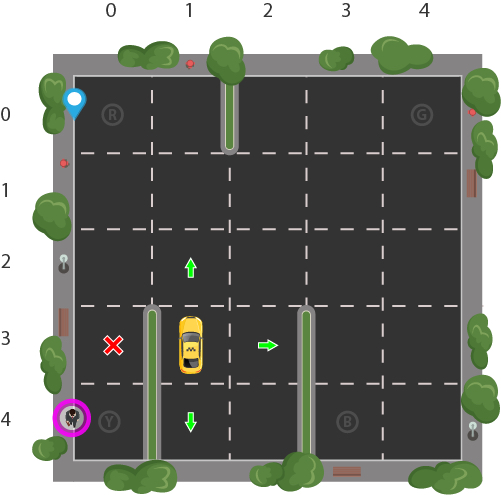

In [91]:
Image(filename = path + "taxiEnvExample.jpeg", width=500, height=500)

Lets get a hang of the environment. We will use taxi-v2 environment from gym
1. Taxi wants to take passengers from one of four (start, end) states
2. Every time it drops a passenger, it gets rewarded 10, any other move incurs a loss of -1
3. Taxi can take left, right, up, down, drop-off, pick Actions
4. [6 actions] There are total of 5 x 5 x 5 x 4 states

- [500 states] Why 5 x 5 x 5 x 4: Well, 5 x 5 is the dimension of the grid. With in each state, there are 5 possibilities of passenger's location (R, G, Y, B or in the taxi). Then there are four destinations. 

So, our taxi environment has 5×5×5×4=500 total possible states.

** Think of table containing a row for each state **

** For each row, we have set of six actions **

***

In [92]:
!pip install pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [93]:
env = gym.make("Taxi-v3").env
env.reset()
#env.render() # NOTE: This function won't run in my environment - Used Google Colab to complete the first section. 

271

**Color Meaning:**

1. Blue -> Start,
2. Pink -> Destination,
3. Yellow -> Empty cab,
4. Green -> Full cab

In [94]:
# env.reset() # reset environment to a new, random state
# env.render()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

Action Space Discrete(6)
State Space Discrete(500)


Keep executing above code to reset environment, you will keep getting different state.

Let us see which state we are at:

In [95]:
env.P[200]

{0: [(1.0, 300, -1, False)],
 1: [(1.0, 100, -1, False)],
 2: [(1.0, 220, -1, False)],
 3: [(1.0, 200, -1, False)],
 4: [(1.0, 200, -10, False)],
 5: [(1.0, 200, -10, False)]}

Let us see our policy at this state

In [96]:
#env.P

Format -- **Action:** [(Probability, state, reward, done)]

***

In [97]:
env.action_space # Running this will tell us the number of actions we have available. 
env.action_space.sample() # Running this will select an action at random. 

2

#### Random Solution

In [98]:
def random_solution():
  
    env.s = 391  # set environment to illustration's state

    epochs = 0
    penalties, reward = 0, 0

    frames = [] # for animation -> Return for animation to work. 

    done = False

    while not done:
        action = env.action_space.sample() # Randomly Select an Action. 
        # Take the selected action and return the relevent values.
        state, reward, done, info = env.step(action) 

        if reward == -10:
          penalties += 1

        # Put each rendered frame into dict for animation
        frames.append({
          'frame': env.render(mode='ansi'),
          'state': state,
          'action': action,
          'reward': reward
          }
        )

        epochs += 1


    print("\nTimesteps taken: {}".format(epochs))
    print("Penalties incurred: {}".format(penalties))
    print("Rewards Total: {}\n".format(reward))

Color Meaning:
1. Blue -> Start, 
2. Pink -> Destination, 
3. Yellow -> Empty cab, 
4. Green -> Full cab

In [99]:
def print_frames(frames):
    
    for i, frame in enumerate(frames):
        
        clear_output(wait=True)
        
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)
        
#print_frames(frames)

In [100]:
env.P[300] 

{0: [(1.0, 400, -1, False)],
 1: [(1.0, 200, -1, False)],
 2: [(1.0, 300, -1, False)],
 3: [(1.0, 300, -1, False)],
 4: [(1.0, 300, -10, False)],
 5: [(1.0, 300, -10, False)]}

***

#### RL Based Solution

In [101]:
q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [102]:
np.shape(q_table)

(500, 6)

In [103]:
%%time
"""Training the agent"""

def q_learning(num_episodes):

    q_table = np.zeros([env.observation_space.n, env.action_space.n])
    episodes = num_episodes
    # Hyperparameters
    alpha = 0.1
    gamma = 0.6
    epsilon = 0.1

    # For plotting metrics
    all_epochs = []
    all_penalties = []

    framesQ = [] # for animation -> Return for animation to work. 

    for i in range(0, episodes):
      
        state = env.reset()

        epochs, penalties, reward, = 0, 0, 0
        done = False

        while not done:

            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample() # Explore action space
            else:
                action = np.argmax(q_table[state]) # Exploit learned values

            next_state, reward, done, info = env.step(action) 

            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])

            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value

            if reward == -10:
                penalties += 1

            state = next_state
            epochs += 1

            # Put each rendered frame into dict for animation
            framesQ.append({
              'frame': env.render(mode='ansi'),
              'state': state,
              'action': action,
              'reward': reward
              }
            )

        if i % 100 == 0:
            clear_output(wait=True)
            print(f"Episode: {i}")

    print("Training finished.\n")
    print("\nTimesteps taken: {}".format(epochs))
    print("Penalties incurred: {}".format(penalties))
    print("Rewards Total: {}\n".format(reward))

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 14.1 µs


In [104]:
def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)
        
#print_frames(framesQ)

In [105]:
# Color Meaning:
# Blue -> Start,
# Pink -> Destination,
# Yellow -> Empty cab,
# Green -> Full cab

## <font color='red'> Activity 1:  Make sure you understand the content in this section, and write your detailed reflections. </font>
#### Use a markdown, in approximately 200 words, discuss your understanding of random solution and Q-learning

Looking over the code above we start with the imported gym module which is used to create the environment with the env = gym.make().env function call. Unfortunately, the environment rendering function won’t seem to work in my environment and attempts to fix this have been unsucsessfull. I found I could run the above on Google Colab.  

Next, we have env.P[200] call which displays the Q-Table values for state 200. Alternatively, env.P will display the entire Q-Table which includes all 500 states along with the potential moves from that state to the next. I notice there is one option that imposes a -10 reward which I would assume relates to the do-nothing action as it has the same state value. The policy information for each state includes the possible states reachable from the current in the following format:<br> 
[(Frame, Probability, State, reward, done)]
* 0 to 5 which is for the animation component. 
* The probability (1.0) as the initial state is designed to encourage exploration. 
* The state, for example, 200.
* The reward value, for example, -1.
* And whether the state is in a termination position, true or false.

Random Based Solution
We then have our random solution code which is essentially a while loop with two main function calls and some bookkeeping. The two calls that do all the work are,
* action = evn.action_space.sample() – Which selects an action from the available options at random. 
* state, reward, done, info = env.step(action) – This takes the action and returns the relevant values to update the policy dict. 

After running the above we can view the process as a mini animation demonstrating the changes in position and values at each state by calling the print_frames() function. Obviously, this achieves nothing as we are simply running a random process with no learning involved. 

RL Based Solution 
For the reinforced learning solution, we require a Q-Table which we initialise as a matrix of zeros with the dimensions of the number of states (500) by the number of actions (6). We then define the number of episodes we wish to run the solution for. An episode represents the agent performing actions until it arrives in a terminating position.  

With the RL-based solution, we have an encompassing for loop around the while loop for the number of epochs specified with the following key differences. 
* We now have 3 hyperparameters, alpha, gamma, and epsilon. 
 * Where alpha is the learning rate, gamma is the discount rate for the Bellman equation and epsilon is the determining value that probabilistically instructs the agent to explore or exploit the environment. In this case, explore 10% of the time.  
* The if-else to deploy the epsilon as described above is a key difference to the random selection solution as we now have the option to select an action that the Q-Table has defined as an optimal solution. This is the exploit portion of the algorithm. 
* Next, we update the Q-Table with the new Q-Value by essentially taking a moving average and multiplying this by our reward value +  the discounted rate (gamma), and multiplying by the next q-max. So, MA * (reward + (gamma * next q-max)) .  
* We do our bookkeeping and repeat this process until the while loop is done and then increment the epoch by one before starting the outer for loop again. 


## <font color='red'> Activity 2:  Running the code with many different test-cases. </font>
#### Write at least 3 test cases for both random solution and Q-learning

In [106]:
#### TODO ####
### Good Luck ###

random_solution() # These functions would only run on Google Colab and not my local environment. 


Timesteps taken: 3397
Penalties incurred: 1075
Rewards Total: 20



In [107]:
random_solution()


Timesteps taken: 321
Penalties incurred: 113
Rewards Total: 20



In [108]:
random_solution()


Timesteps taken: 2
Penalties incurred: 0
Rewards Total: 20



In [109]:
q_learning(5000)

Episode: 4900
Training finished.


Timesteps taken: 9
Penalties incurred: 0
Rewards Total: 20



In [110]:
q_learning(10000)

Episode: 9900
Training finished.


Timesteps taken: 14
Penalties incurred: 0
Rewards Total: 20



In [111]:
q_learning(20000)

Episode: 19900
Training finished.


Timesteps taken: 15
Penalties incurred: 0
Rewards Total: 20



## <font color='red'> Activity 3: Formulate the algorithms for the integration of Monte Carlo Tree Search in Reinforcement Learning. Explain how AlphaGo's algorithm that beat Lee Sedol in game of Go. </font>
#### Add a dedicated section in your report!

In [112]:
#### TODO ####
### Leave this part blank, and complete this activity in your report ###

***

### Section 2: MapReduce

Let us see the code for Map and Reduce version of Word count

In [113]:
#dir_name = '/Users/nayyarz/OneDrive - Deakin University/Teaching/SIT320/Demos/data'
#dir_name = '/Users/michaelwiedermann/DEV/SIT320/WK11_misc_algorithms/data'
dir_name = 'data'

I will make use of python's dictionary to simulate map operation. I will also not output data to a file, but will keep it in the memory

Our map function looks like:

In [114]:
from collections import Counter

def map_myapp(arg):

    data = [] 
    kv_map = {}

    for fname in os.listdir(arg):

        if fname[-4:] == '.txt':
            print('Processing {}'.format(fname))

            f = open(os.path.join(dir_name, fname))
            data = f.read()
            f.close()

            # get rid of whitespace  
            line = data.strip() 
            
            # split the line into words  
            words = line.split()
            
            # use counter for counting the words
            cnt = Counter(words)
            
            # Putting result in key-value pairs in form of dictionary
            kv_doc = {}

            for key, value in cnt.items():
                kv_doc[key] = value

            kv_map[fname] = kv_doc
            
    return kv_map

In [115]:
kv_map = map_myapp(dir_name)


Processing articles_101.txt
Processing articles_100.txt


Let us see if we can develop a reduce

Note, I will assuming that only relevant dictionaries are provided to the reduce function

In [116]:
def reduce_myapp(kv_map):
    
    meta_dict = {}

    kv_map_keys = list(kv_map.keys())

    for i in kv_map_keys:
        kv_map_i = kv_map[i]

        print('Processing {}'.format(i))

        for k, v in kv_map_i.items():

            if k in meta_dict:
                meta_dict[k] += v
            else:
                meta_dict[k] = v
                
    return meta_dict

In [117]:
kv_reduce = reduce_myapp(kv_map)

Processing articles_101.txt
Processing articles_100.txt


In [118]:
kv_reduce['that']

177

In [119]:
kv_map['articles_101.txt']['that']

79

In [120]:
kv_map['articles_100.txt']['that']

98

## <font color='red'> Activity 4:  Make sure you understand the content in this section, and write your detailed reflections. </font>
#### Having after tested the code of Map Reduce, use a markdown, in approximately 200 words, discuss your understanding of it!

The simulation code consists of two functions, map_myapp() and reduce_myapp(). The first function imitates our map functions and utilises the Counter class, a subclass of Dictionary which is used to track elements and their count and begins by declaring a list called data[] and a dictionary called kv_map{}.  

The function then moves into a for loop for the number of files in the directory. 
Then an if condition to ensure only files ending in “.txt” are processed. 
1.	Print the name of the file being processed.
2.	Open the file and return a stream to “f”. 
3.	Read the stream into “data” then close the file stream.
4.	Removes white space from the text file and splits the lines into words.
5.	Using the counter, count the occurrence of each word and return as a word-count pair.  
6.	Finally, a for loop to add each word-count for each file to a data dict as a key-value pair and return.

The map function essentially returns the files as two data dictionaries simulating what two nodes would return. We now need to reduce them into a searchable file.

The second function, reduce_myapp(), which imitates the reduce function starts with the declaration of a metadata dictionary and then copies the keys from the “Map” created above and passed to the function to a list “kv_map_keys” which represents each dictionary, 2 of. The function then moves into a for loop:
1.	The outer loop loops once for each dict (file) and while doing so copies each dict to “kv_map_i”.  
2.	The inner for loop then adds each key-value pair to the new meta_dict() combining any duplicates between the two files. 
3.	Lastly, the new meta dict is returned. 

The final object kv_reduce is a searchable dict with all words and their counts easily searchable. 










***

## <font color='red'> Activity 5: Write down Map and Reduce functions for performing Matrix Multiplication. </font>

In [121]:
#### TODO ####
### Good Luck ###
# The test Matrices 
A = np.array([[1,6,2],[3,7,3]]) # ,[9,1,4]
B = np.array([[5,5],[2,9],[3,2]]) # B = np.array([[5,5,6],[2,9,2],[3,2,1]])

print(A,'\n')
print(B)

# The target result. 
np.dot(A, B)

[[1 6 2]
 [3 7 3]] 

[[5 5]
 [2 9]
 [3 2]]


array([[23, 63],
       [38, 84]])

In [122]:
def matrix_map(A, B):
    # Main dict plus sub dicts for each matix.
    kv_dict = {}
    kv_dict['a'] = {}
    kv_dict['b'] = {}
    # Getting the shape of each matrix
    a_m, a_n = A.shape
    b_m, b_n = B.shape
    
    if (a_n != b_m):
        print(' ERROR: Matrices are not compatible')
        return None
    
    for i in range(a_m): # Map A (row, column, add pos.)
        for j in range(a_m):
            for k in range(a_n):
                kv_dict['a'][f'{i+1}_{j+1}_{k+1}'] = A[i][k]
            
    for i in range(b_n): # Map B (row, column, add pos.)
        for j in range(b_n):
            for k in range(b_m):
                kv_dict['b'][f'{i+1}_{j+1}_{k+1}'] = B[k][j]
    
    return kv_dict

In [123]:
def matrix_reduce(m_map):
    # Dictionaries for building final output
    multiplication = {}
    addition = {}    
    row, col = 0, 0 
    
    for k in m_map.keys(): 
        # Iterate over both matrices
        for j in m_map[k].keys():
            r, c, n = j.split('_')
            row = max(row, int(r)) #Find the number of rows for the output array
            col = max(col, int(c)) #Find the number of columns for the output array
            
            if multiplication.get(j):
                #Check if the same index was already found in the other matrix
                multiplication[j] = multiplication[j] * m_map[k][j] #Multiply
                addition[r+'_'+c] += multiplication[j] #Add result to addition matrix
            else:
                multiplication[j] = m_map[k][j]
                addition[r + '_' + c] = 0 #Create entry in addition matrix
    
    #Create output array of size (row, col)
    output = np.zeros([row, col])
    
    #Build output array from addition matrix
    for i in addition.keys():
        #Split keys to get indexes
        r, c = i.split('_')
        r, c = int(r)-1, int(c)-1
        output[r][c] = addition[i]

    return output

In [124]:
m_map = matrix_map(A, B)

# Confirming mapping
print(m_map)

{'a': {'1_1_1': 1, '1_1_2': 6, '1_1_3': 2, '1_2_1': 1, '1_2_2': 6, '1_2_3': 2, '2_1_1': 3, '2_1_2': 7, '2_1_3': 3, '2_2_1': 3, '2_2_2': 7, '2_2_3': 3}, 'b': {'1_1_1': 5, '1_1_2': 2, '1_1_3': 3, '1_2_1': 5, '1_2_2': 9, '1_2_3': 2, '2_1_1': 5, '2_1_2': 2, '2_1_3': 3, '2_2_1': 5, '2_2_2': 9, '2_2_3': 2}}


In [125]:
# Test Case 1 - 2x3 and a 3x2 matrix

results = matrix_reduce(m_map)
print(results)
np.dot(A, B)

[[23. 63.]
 [38. 84.]]


array([[23, 63],
       [38, 84]])

In [126]:
# Test Case 2 - 3x3 and a 3x3 matrix

A2 = np.array([[1,6,2],[3,7,3],[9,1,4]]) 
B2 = np.array([[5,5,6],[2,9,2],[3,2,1]])

m_map2 = matrix_map(A2, B2)
results2 = matrix_reduce(m_map2)
print(results2)
np.dot(A2, B2)

[[23. 63. 20.]
 [38. 84. 35.]
 [59. 62. 60.]]


array([[23, 63, 20],
       [38, 84, 35],
       [59, 62, 60]])

In [127]:
# Test Case 3 - 3x2 and a 2x3 matrix

A3 = np.array([[5,5],[2,9],[3,2]])
B3 = np.array([[1,6,2],[3,7,3]]) 

m_map3 = matrix_map(A3, B3)
results3 = matrix_reduce(m_map3)
print(results3)
np.dot(A3, B3)

[[20. 65. 25.]
 [29. 75. 31.]
 [ 9. 32. 12.]]


array([[20, 65, 25],
       [29, 75, 31],
       [ 9, 32, 12]])

## <font color='red'> Activity 6: Formulate a MapReduce variation with the algorithm we have studied in this unit </font>
#### Add a dedicated section in your report!

In [128]:
#### TODO ####
### Leave this part blank, and complete this activity in your report ###

***